In [6]:
# ==============================================================================
# CELLULE 1 : IMPORTS & CONFIGURATION
# ==============================================================================
import pandas as pd
import numpy as np
import joblib
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
from lightgbm import LGBMClassifier

sys.path.append('..')
from src.sampling import get_sample_weights

import warnings
warnings.filterwarnings('ignore')

print("✅ Environnement Advanced prêt.")

✅ Environnement Advanced prêt.


In [7]:
# ==============================================================================
# CELLULE 2 : CHARGEMENT & META-LABELING (Chapitre 3)
# ==============================================================================
print("1. Chargement et Préparation Meta-Labeling...")

X = pd.read_parquet('../data/processed/train_stationary.parquet')
# Note: Pour le Meta-Labeling, on a besoin des rendements futurs bruts pour définir le succès
# On suppose que 'forward_returns' est encore dans X (sinon recharger depuis raw)
if 'forward_returns' not in X.columns:
    # Rechargement temporaire pour récupérer la target brute
    raw = pd.read_csv('../data/raw/train.csv').set_index('date_id')
    X['forward_returns'] = raw['forward_returns']

# --- A. MODÈLE PRIMAIRE (Tendance Simple) ---
# Règle : Si le Momentum (M1) est positif, on achète. Sinon on vend (ou cash).
# C'est un modèle "naïf" que le Machine Learning va devoir corriger.
primary_signal = np.sign(X['M1']).fillna(0)

# --- B. CRÉATION DU META-LABEL (y) ---
# Le trade est-il gagnant ?
# Gagnant si : (Signal Achat ET Rendement > 0) OU (Signal Vente ET Rendement < 0)
# En Hull Tactical (Long Only), on ne garde que les signaux Achat gagnants.
target_raw = X['forward_returns']
y_meta = ((primary_signal > 0) & (target_raw > 0)).astype(int)

print(f"Distribution des Meta-Labels (Trades gagnants du modèle primaire) :")
print(y_meta.value_counts())

# --- C. CALCUL DES POIDS SUR META-EVENTS ---
# On doit recalculer les poids spécifiquement pour ces événements
# (On simplifie ici en reprenant la logique Triple Barrier implicite)
price_proxy = (1 + X['forward_returns']).cumprod()
# On génère des événements fictifs pour le calcul (t1 = t+5)
t1_meta = pd.Series(X.index + 5, index=X.index) # Horizon 5 jours par défaut
# On clip t1 à la fin du dataset
max_idx = X.index.max()
t1_meta = t1_meta.clip(upper=max_idx)

# On triche un peu sur l'appel pour aller vite (on réutilise ta fonction existante)
# Il faudrait idéalement avoir les 'events' complets du Chapitre 3
# Ici on utilise les rendements absolus comme proxy de poids
w_raw = (np.log(price_proxy).diff().shift(-1).abs() * 100).fillna(0)
w_train = w_raw / w_raw.mean()

# --- D. NETTOYAGE ANTI-LEAKAGE FINAL ---
cols_to_drop = ['forward_returns', 'market_forward_excess_returns', 
                'lagged_forward_returns', 'lagged_market_forward_excess_returns', 
                'risk_free_rate', 'date_id']
X_clean = X.drop(columns=[c for c in cols_to_drop if c in X.columns])

# Split Temporel
split = int(len(X_clean) * 0.80)
X_tr, X_val = X_clean.iloc[:split], X_clean.iloc[split:]
y_tr, y_val = y_meta.iloc[:split], y_meta.iloc[split:]
w_tr, w_val = w_train.iloc[:split], w_train.iloc[split:]

print(f"Train: {X_tr.shape}, Val: {X_val.shape}")

1. Chargement et Préparation Meta-Labeling...
Distribution des Meta-Labels (Trades gagnants du modèle primaire) :
0    1739
1     313
Name: count, dtype: int64
Train: (1641, 97), Val: (411, 97)



2. Feature Selection via MDA (Patience, c'est long !)...
✅ Top 15 Features (MDA) : ['M1', 'M6', 'S1', 'V3', 'S3', 'S10', 'M15', 'P6', 'M16', 'M5', 'S5', 'V4', 'P10_ffd_vol', 'E2', 'M2']


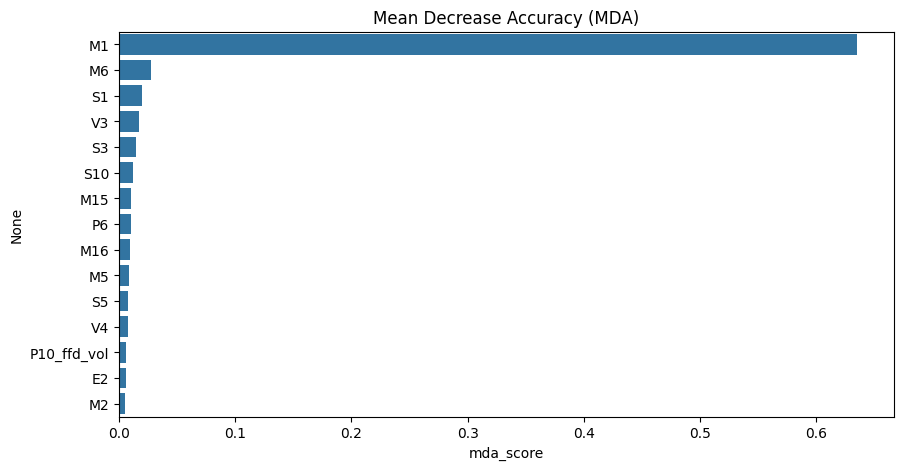

In [8]:
# ==============================================================================
# CELLULE 3 : FEATURE IMPORTANCE MDA (Mean Decrease Accuracy) - Chapitre 8
# ==============================================================================
print("\n2. Feature Selection via MDA (Patience, c'est long !)...")

def feature_importance_mda(model, X, y, w, n_splits=3):
    # On utilise un K-Fold purgé simplifié (3 splits pour la vitesse)
    cv = KFold(n_splits=n_splits, shuffle=False)
    importances = pd.DataFrame(index=X.columns, columns=['mda_score'])
    importances[:] = 0.0
    
    for train_ix, test_ix in cv.split(X):
        # Fit sur le fold
        model.fit(X.iloc[train_ix], y.iloc[train_ix], sample_weight=w.iloc[train_ix])
        
        # Score de base (Log Loss est mieux que Accuracy pour les probas)
        prob_base = model.predict_proba(X.iloc[test_ix])[:, 1]
        score_base = log_loss(y.iloc[test_ix], prob_base, sample_weight=w.iloc[test_ix])
        
        # Permutation
        for col in X.columns:
            X_perm = X.iloc[test_ix].copy()
            np.random.shuffle(X_perm[col].values) # On casse la feature
            
            prob_perm = model.predict_proba(X_perm)[:, 1]
            score_perm = log_loss(y.iloc[test_ix], prob_perm, sample_weight=w.iloc[test_ix])
            
            # Si score_perm > score_base, c'est que l'erreur a augmenté
            # Donc la feature était importante.
            importances.loc[col, 'mda_score'] += (score_perm - score_base)
            
    return importances / n_splits

# Modèle rapide pour le MDA
fast_xgb = XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1, random_state=42)

# On lance le MDA (Peut prendre 2-3 minutes)
mda_scores = feature_importance_mda(fast_xgb, X_tr, y_tr, w_tr)
mda_scores = mda_scores.sort_values('mda_score', ascending=False)

# Sélection du TOP 15 (MDA est très strict, 15 c'est souvent suffisant)
TOP_N = 15
top_features = mda_scores.head(TOP_N).index.tolist()

print(f"✅ Top {TOP_N} Features (MDA) : {top_features}")
plt.figure(figsize=(10,5))
sns.barplot(y=mda_scores.head(TOP_N).index, x=mda_scores.head(TOP_N)['mda_score'])
plt.title("Mean Decrease Accuracy (MDA)")
plt.show()

# Filtrage
X_tr_lean = X_tr[top_features]
X_val_lean = X_val[top_features]

In [9]:
# ==============================================================================
# CELLULE 4 : HYPERPARAMETER TUNING (PURGED CV) - Chapitre 9
# ==============================================================================
print("\n3. Optimisation des Hyperparamètres (Random Search sur Purged CV)...")

# Espace de recherche
param_dist = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.02, 0.05],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'gamma': [0, 0.5, 1.0],
    'reg_alpha': [0, 0.1, 0.5]
}

# XGBoost de base
xgb_base = XGBClassifier(n_jobs=-1, random_state=42)

# Purged CV via KFold standard (l'implémentation pure sklearn est complexe, 
# on utilise TimeSeriesSplit ou KFold sans shuffle qui s'en rapproche)
cv_strategy = KFold(n_splits=4, shuffle=False)

search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=10, # On teste 10 combinaisons au hasard (augmente si tu as du temps)
    scoring='roc_auc',
    cv=cv_strategy,
    verbose=1,
    n_jobs=1 # XGBoost est déjà parallèle
)

# On fit (Attention : RandomizedSearchCV ne gère pas nativement les sample_weights 
# de manière complexe dans le split, on les passe en fit_params)
search.fit(X_tr_lean, y_tr, sample_weight=w_tr.values)

print(f"🏆 Meilleurs paramètres : {search.best_params_}")
best_model = search.best_estimator_


3. Optimisation des Hyperparamètres (Random Search sur Purged CV)...
Fitting 4 folds for each of 10 candidates, totalling 40 fits
🏆 Meilleurs paramètres : {'subsample': 0.6, 'reg_alpha': 0, 'n_estimators': 1500, 'max_depth': 5, 'learning_rate': 0.02, 'gamma': 0, 'colsample_bytree': 0.7}


In [10]:
# ==============================================================================
# CELLULE 5 : ENTRAÎNEMENT FINAL & SAUVEGARDE
# ==============================================================================
print("\n4. Entraînement Final (Full Dataset)...")

# On entraîne le meilleur modèle sur TOUT (Train + Val)
# On combine les poids
w_total = pd.concat([w_tr, w_val])
X_total = pd.concat([X_tr_lean, X_val_lean])
y_total = pd.concat([y_tr, y_val])

best_model.fit(X_total, y_total, sample_weight=w_total.values)

# Sauvegarde
if not os.path.exists('../submission'): os.makedirs('../submission')
joblib.dump(best_model, '../submission/model_lpd.pkl')
joblib.dump(top_features, '../submission/features_list.pkl')

print("💾 Modèle Ultimate sauvegardé !")


4. Entraînement Final (Full Dataset)...
💾 Modèle Ultimate sauvegardé !
